In [1]:
%load_ext autoreload
%autoreload 2

# Imports

Import all necessary packages and modules

In [2]:
import numpy as np
import pandas as pd
import math

from collections import defaultdict
from matplotlib import pyplot as plt
from project.utils import get_performances, plot_performances, plot_ci
from project.src import FixedDosage, ClinicalDosing, PharmacogeneticDosing, LinUCB, ThompsonSampling, EnsembleSampling

# 0. Data loading

Load the given data as a pandas dataframe

In [3]:
df = pd.read_csv(r"../rsrc/data.csv")

In [4]:
df.shape

(5701, 66)

Visualize the dataframe

In [5]:
df.head()

,PharmGKB Subject ID,Gender,Race,Ethnicity,Age,Height (cm),Weight (kg),Indication for Warfarin Treatment,Comorbidities,Diabetes,...,VKORC1 -1639 consensus,VKORC1 497 consensus,VKORC1 1173 consensus,VKORC1 1542 consensus,VKORC1 3730 consensus,VKORC1 2255 consensus,VKORC1 -4451 consensus,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,PA135312261,male,White,not Hispanic or Latino,60 - 69,193.04,115.7,7,No Cancer,NaN,...,A/G,G/T,NaN,C/G,A/G,NaN,NaN,NaN,NaN,NaN
1,PA135312262,female,White,not Hispanic or Latino,50 - 59,176.53,144.2,7,Cancer,NaN,...,A/A,G/T,T/T,C/C,G/G,T/T,C/C,NaN,NaN,NaN
2,PA135312263,female,White,not Hispanic or Latino,40 - 49,162.56,77.1,7,No Cancer,NaN,...,G/G,T/T,NaN,G/G,A/G,NaN,NaN,NaN,NaN,NaN
3,PA135312264,male,White,not Hispanic or Latino,60 - 69,182.24,90.7,7,No Cancer,NaN,...,A/G,G/T,NaN,C/G,G/G,NaN,NaN,NaN,NaN,NaN
4,PA135312265,male,White,not Hispanic or Latino,50 - 59,167.64,72.6,7,No Cancer,NaN,...,A/G,T/T,NaN,C/G,A/G,NaN,NaN,NaN,NaN,NaN


# 1. Data cleaning and feature engineering

The given dataframe has 3 an additional 3 columns in the end which have no values. Dropping those columns.

In [6]:
df = df.dropna(axis=1, how='all')

In [7]:
df.shape

(5701, 63)

Drop the rows where the ground truth (GT) i.e. the therapeutic dose of Warfarin is unknown

In [8]:
df = df.dropna(subset=["Therapeutic Dose of Warfarin"])

In [9]:
df.shape

(5528, 63)

In [10]:
f"{5701 - 5529} rows dropped"

'172 rows dropped'

Impute missing values for certain columns based on `appx.pdf`

In [11]:
# Rename columns of VKORC1 SNPs for convenience
df = df.rename(
    columns={
        "VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T": "rs9923231",
        "VKORC1 genotype: 1173 C>T(6484); chr16:31012379; rs9934438; A/G": "rs9934438",
        "VKORC1 genotype: 1542G>C (6853); chr16:31012010; rs8050894; C/G": "rs8050894",
        "VKORC1 genotype: 2255C>T (7566); chr16:31011297; rs2359612; A/G": "rs2359612",
    }
)

# Imputation of missing values
df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs2359612"] == "C/C"),
    "rs9923231",
] = "G/G"

df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs2359612"] == "T/T"),
    "rs9923231",
] = "A/A"

df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs2359612"] == "C/T"),
    "rs9923231",
] = "A/G"


df.loc[
    df["rs9923231"].isna() & (df["rs9934438"] == "C/C"),
    "rs9923231",
] = "G/G"

df.loc[
    df["rs9923231"].isna() & (df["rs9934438"] == "T/T"),
    "rs9923231",
] = "A/A"

df.loc[
    df["rs9923231"].isna() & (df["rs9934438"] == "C/T"),
    "rs9923231",
] = "A/G"

df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs8050894"] == "G/G"),
    "rs9923231",
] = "G/G"

df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs8050894"] == "C/C"),
    "rs9923231",
] = "A/A"

df.loc[
    df["rs9923231"].isna()
    & ((df["Race"] != "Black or African American") | (df["Race"] != "Unknown"))
    & (df["rs8050894"] == "C/G"),
    "rs9923231",
] = "A/G"

Bucket age data based on the decade

In [12]:
def bucket_age(age):
    if isinstance(age, str):
        return int(age[0])
    else:
        return age

df['Age bucket'] = df['Age'].apply(bucket_age)

Add feature "enzyme inducer status" based on the medication that the patient is taking

In [13]:
# Enzyme inducer status = 1 if patient taking carbamazepine, phenytoin, rifampin, or rifampicin, otherwise zero
# Note: Enxyme inducer status is set to 0 by default if the three parameters are np.nan

for i, df_row in df.iterrows():
    if (
        np.isnan(df_row['Carbamazepine (Tegretol)'])
        & np.isnan(df_row['Phenytoin (Dilantin)'])
        & np.isnan(df_row['Rifampin or Rifampicin'])
    ):
        df.loc[i, 'Enzyme inducer status'] = np.nan
    else:
        df.loc[i, 'Enzyme inducer status'] = (
            ~np.isnan(df_row['Carbamazepine (Tegretol)']) & bool(df_row['Carbamazepine (Tegretol)'])
            | ~np.isnan(df_row['Phenytoin (Dilantin)']) & bool(df_row['Phenytoin (Dilantin)'])
            | ~np.isnan(df_row['Rifampin or Rifampicin']) & bool(df_row['Rifampin or Rifampicin'])
        ) * 1

In [14]:
df.shape

(5528, 65)

Deal with missing values in the dataset

There are two ways to tackle this problem:
1) impute_missing_values = True. In this case, missing values of hte relevant columns are estimated using the values that are already present
2) impute_missing_values = False. In this case, the datapoints having missing values are ignored and dropped from the dataset

In [15]:
impute_missing_values = False

In [16]:
# If impute_missing_values is True, impute the missing values in the required datapoints

if impute_missing_values:
    df['Age bucket'] = df['Age bucket'].fillna(int(df['Age bucket'].mean()))
    df['Height (cm)'] = df['Height (cm)'].fillna(df['Height (cm)'].mean())
    df['Weight (kg)'] = df['Weight (kg)'].fillna(df['Weight (kg)'].mean())
    df['Enzyme inducer status'] = df['Enzyme inducer status'].fillna(0)
    df['Amiodarone (Cordarone)'] = df['Amiodarone (Cordarone)'].fillna(0)

In [17]:
df = df.dropna(subset=['Age', 'Height (cm)', 'Weight (kg)', 'Amiodarone (Cordarone)', 'Enzyme inducer status'], how='any')

In [18]:
df.shape

(2127, 65)

Bucket the GTs into specific buckets:

- Low: 0
- Medium: 1
- High: 2

In [19]:
# Low
df.loc[df['Therapeutic Dose of Warfarin'] < 21, 'GT'] = 0

# Medium
df.loc[
    (21 <= df['Therapeutic Dose of Warfarin'])
    & (df['Therapeutic Dose of Warfarin'] <= 49),
    'GT'
] = 1

# High
df.loc[49 < df['Therapeutic Dose of Warfarin'], 'GT'] = 2


# Correct column type
df['GT'] = df['GT'].astype(int)

In [20]:
df['GT'].value_counts()

1    1354
0     433
2     340
Name: GT, dtype: int64

Encode certain columns:

- Binary encoding: Gender
- One hot encoding: Race, Ethnicity

In [21]:
# Gender
df['Gender'] = df['Gender'].apply(lambda gender: 0 if gender=='male' else 1)

# Race
df = pd.get_dummies(data=df, prefix=['Race', 'Ethnicity'], columns=['Race', 'Ethnicity'])

In [22]:
df.shape

(2127, 71)

Reset dataframe index

In [23]:
df = df.reset_index()
df = df.drop(columns=['index'])

Create a fexed set of shuffled datasets to feed to each algorithm

In [24]:
dfs = [
    df.sample(frac=1).reset_index().drop(columns=['index'])
    for _ in range(20)
]

len(dfs)

20

# 2. Baselines

### 2.1 Fixed Dosage algorithm

In [25]:
model = FixedDosage(fixed_arm=1)

In [26]:
model.set_data(df)

In [27]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [28]:
model.get_final_performances()

{'fraction of incorrect doses': 0.3634226610249177, 'cumulative regret': 773}

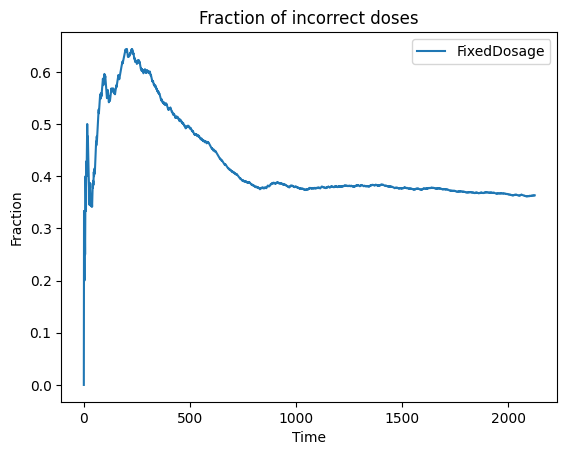

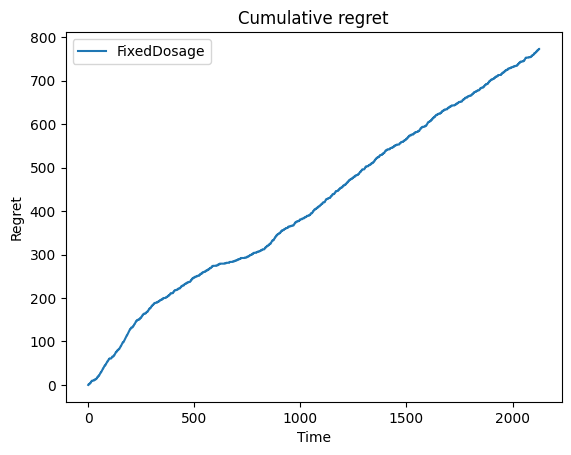

In [29]:
model.plot_performances()

#### Measure performance

In [30]:
performance_histories = defaultdict(list)

for i in range(20):
    model = FixedDosage(fixed_arm=1)
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

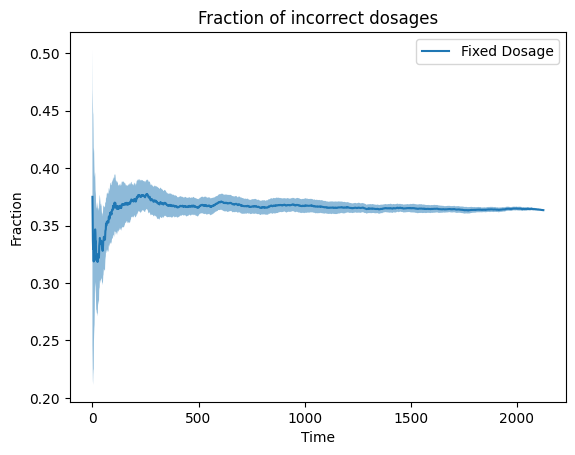

In [31]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'Fixed Dosage',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

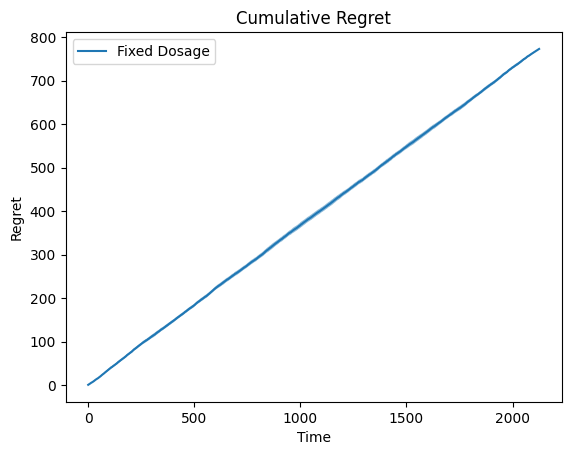

In [32]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'Fixed Dosage',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [33]:
fixed_dosage_performance = performance_histories

#### Measure robustness

In [34]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [35]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.36342266102491766
cumulative regret          :	773.0


In [36]:
fixed_dosage_robustness = final_performances

### 2.2 Clinicial Dosing Algorithm

In [37]:
model = ClinicalDosing()

In [38]:
model.set_data(df)

In [39]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [40]:
model.get_final_performances()

{'fraction of incorrect doses': 0.35778091208274565, 'cumulative regret': 761}

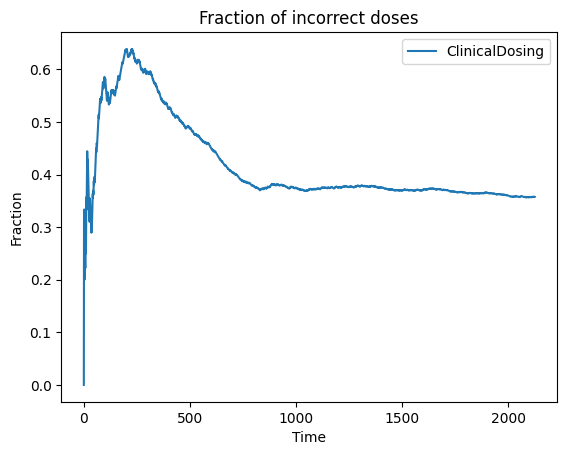

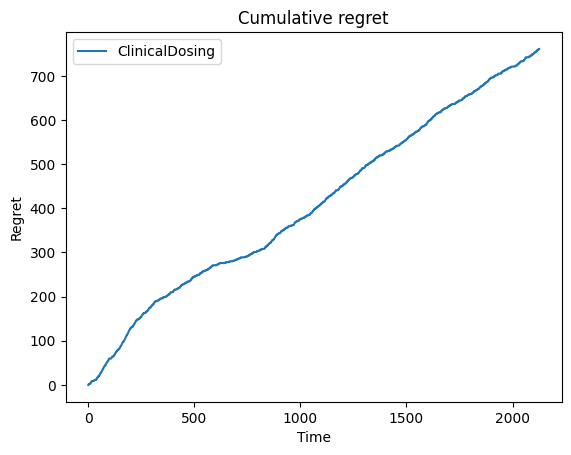

In [41]:
model.plot_performances()

#### Measure performance

In [42]:
performance_histories = defaultdict(list)

for i in range(20):
    model = ClinicalDosing()
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

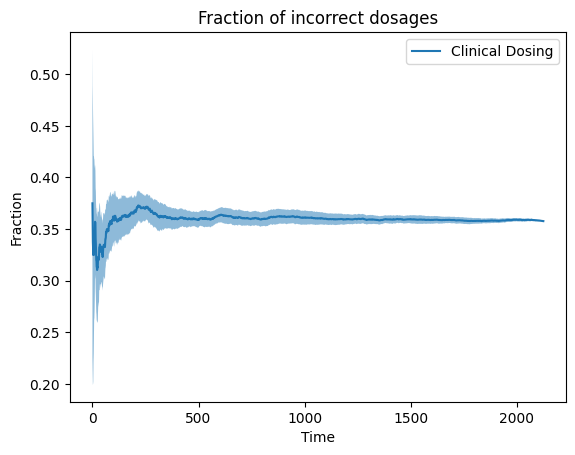

In [43]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'Clinical Dosing',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

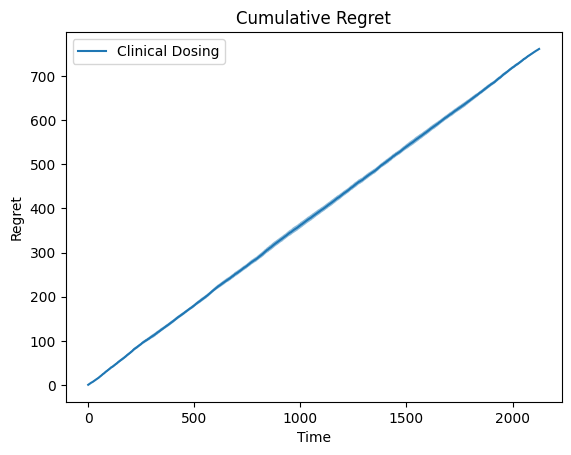

In [44]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'Clinical Dosing',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [45]:
clinical_dosing_performance = performance_histories

#### Measure robustness

In [46]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [47]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.3577809120827456
cumulative regret          :	761.0


In [48]:
clinical_dosing_robustness = final_performances

### 2.3 Pharmacogenetic Dosing Algorithm

In [49]:
model = PharmacogeneticDosing()

In [50]:
model.set_data(df)

In [51]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [52]:
model.get_final_performances()

{'fraction of incorrect doses': 0.3305124588622473, 'cumulative regret': 703}

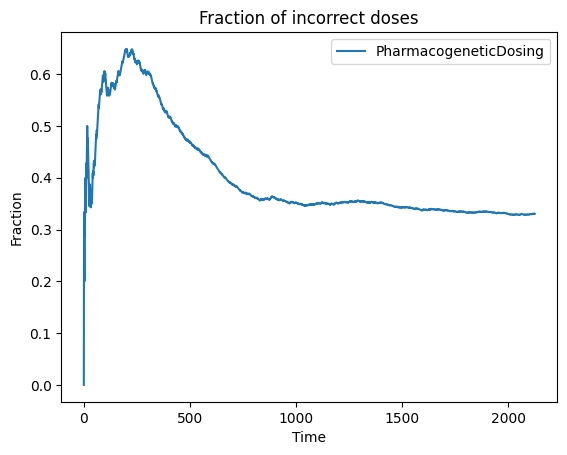

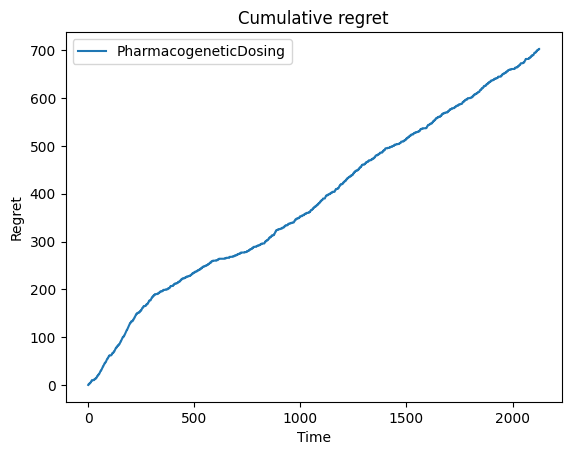

In [53]:
model.plot_performances()

#### Measure performance

In [54]:
performance_histories = defaultdict(list)

for i in range(20):
    model = PharmacogeneticDosing()
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

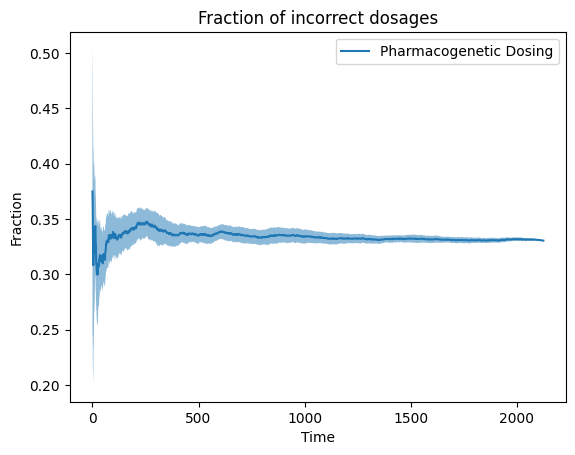

In [55]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'Pharmacogenetic Dosing',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

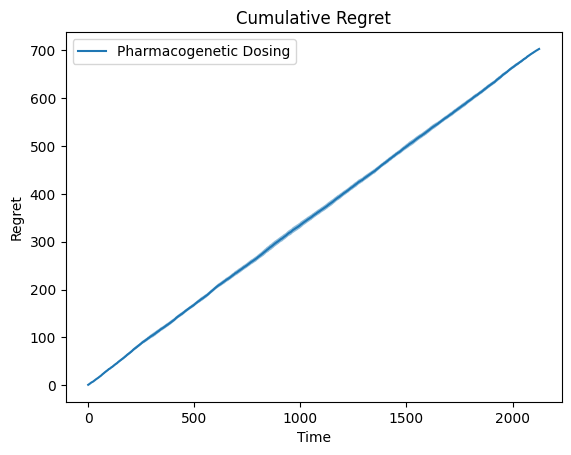

In [56]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'Pharmacogenetic Dosing',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [57]:
pharmacogenetic_dosing_performance = performance_histories

#### Measure robustness

In [58]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [59]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.33051245886224734
cumulative regret          :	703.0


In [60]:
pharmacogenetic_dosing_robustness = final_performances

# 3. Implementing a Linear Bandit Algorithm on Warfarin Dataset 

### 3.1 Thompson Sampling for Contextual Bandits with Linear Payoffs

#### Check model

In [61]:
model = ThompsonSampling(3, 0.05)

In [62]:
model.set_data(df)

In [63]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [64]:
model.get_final_performances()

{'fraction of incorrect doses': 0.34931828866948755, 'cumulative regret': 743}

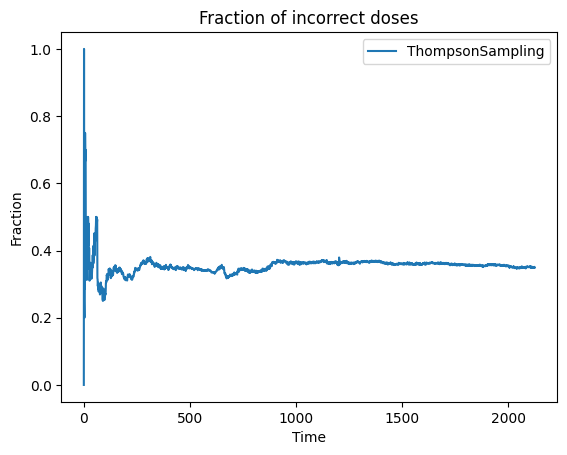

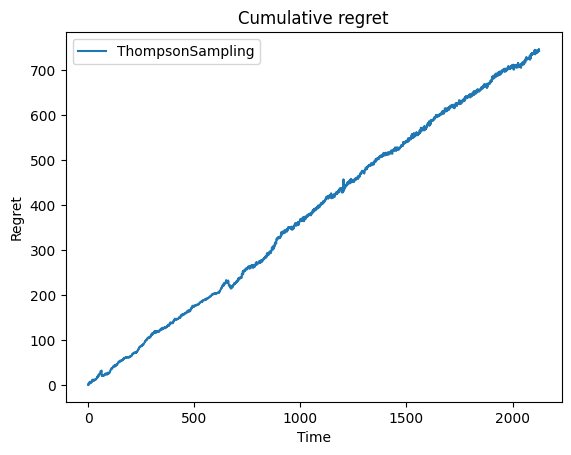

In [65]:
model.plot_performances()

#### Measure performance

In [66]:
performance_histories = defaultdict(list)

for i in range(20):
    model = ThompsonSampling(3, 0.05)
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

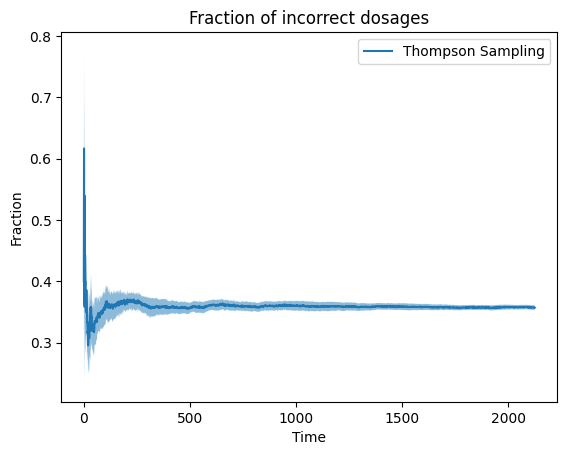

In [67]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'Thompson Sampling',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

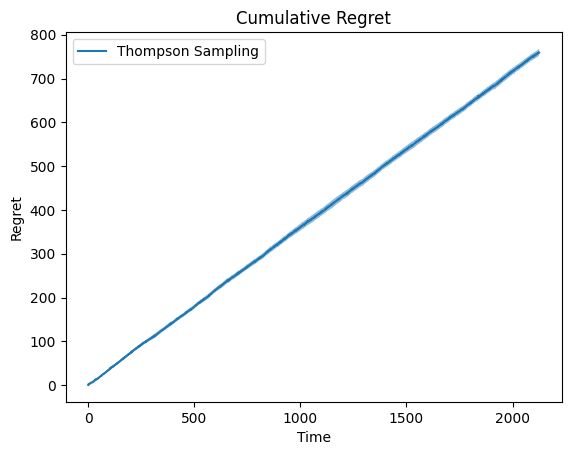

In [68]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'Thompson Sampling',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [69]:
thompson_sampling_performance = performance_histories

#### Measure robustness

In [70]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [71]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.3570756934649741
cumulative regret          :	759.5


In [72]:
thompson_sampling_robustness = final_performances

### 3.2 LinUCB with disjoint linear models

In [73]:
d = 0.01

alpha = 1 + np.sqrt(np.log(2 / d) / 2)
alpha

2.6276236307187295

#### Check model

In [74]:
model = LinUCB(3, alpha)

In [75]:
model.set_data(df)

In [76]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [77]:
model.get_final_performances()

{'fraction of incorrect doses': 0.3540197461212976, 'cumulative regret': 753}

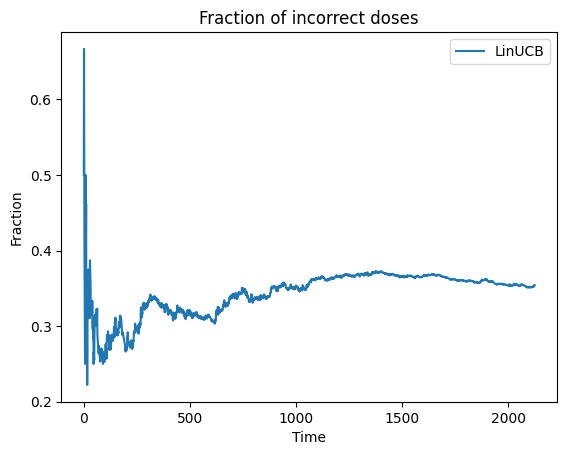

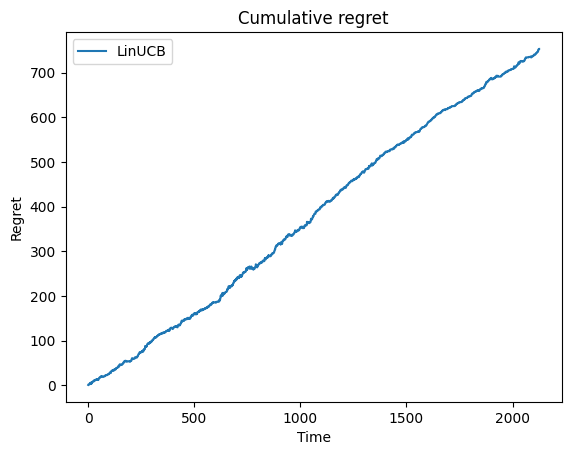

In [78]:
model.plot_performances()

#### Measure performance

In [79]:
performance_histories = defaultdict(list)

for i in range(20):
    model = LinUCB(3, alpha)
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

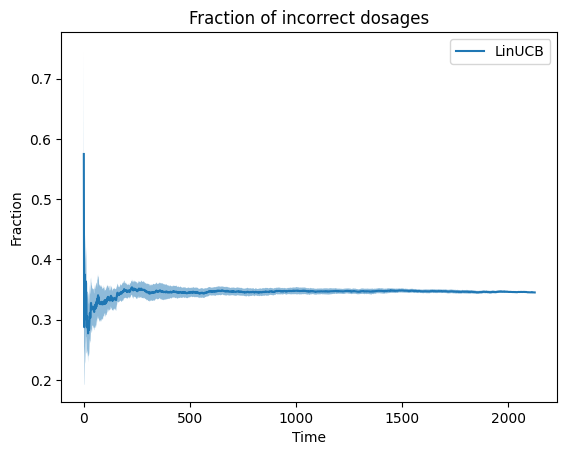

In [80]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'LinUCB',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

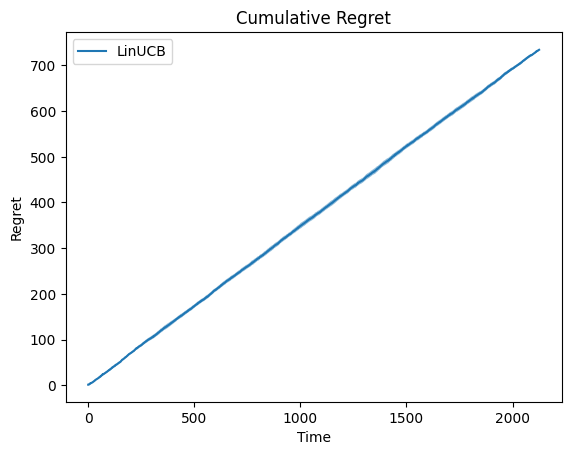

In [81]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'LinUCB',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [82]:
linucb_performance = performance_histories

#### Measure robustness

In [83]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [84]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.3451810061118947
cumulative regret          :	734.2


In [85]:
linucb_robustness = final_performances

### 3.3 Ensemble Sampling

#### Check model

In [86]:
model = EnsembleSampling(3, 5, 0.001)

In [87]:
model.set_data(df)

In [88]:
model.train()

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

In [89]:
model.get_final_performances()

{'fraction of incorrect doses': 0.35731076633756464, 'cumulative regret': 760}

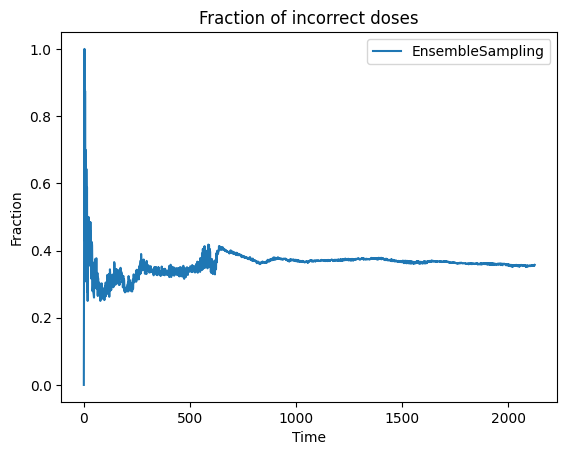

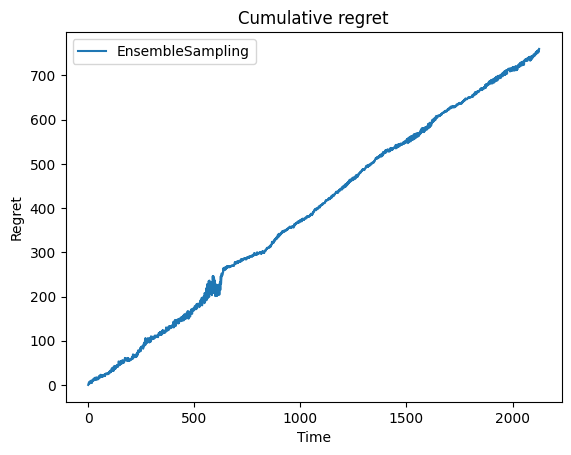

In [90]:
model.plot_performances()

#### Measure performance

In [91]:
performance_histories = defaultdict(list)

for i in range(20):
    model = EnsembleSampling(3, 20, 0.001)
    model.set_data(dfs[i])
    model.train()
    
    for key, history in model.performance_history.items():
        performance_histories[key].append(history)

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

Training:   0%|          | 0/2127 [00:00<?, ?it/s]

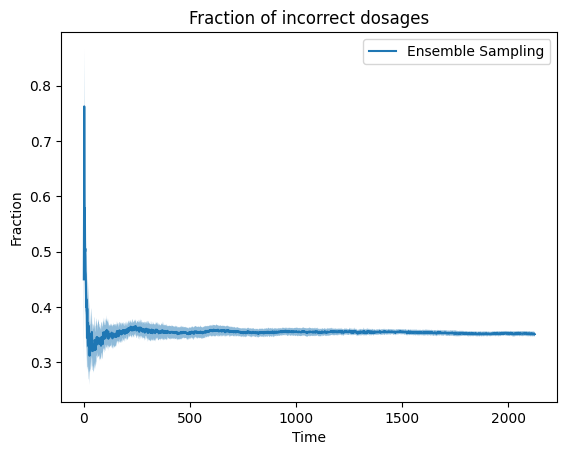

In [92]:
plot_performances(
    np.array(performance_histories['fraction of incorrect doses']),
    'Ensemble Sampling',
    'Time',
    'Fraction',
    'Fraction of incorrect dosages'
)

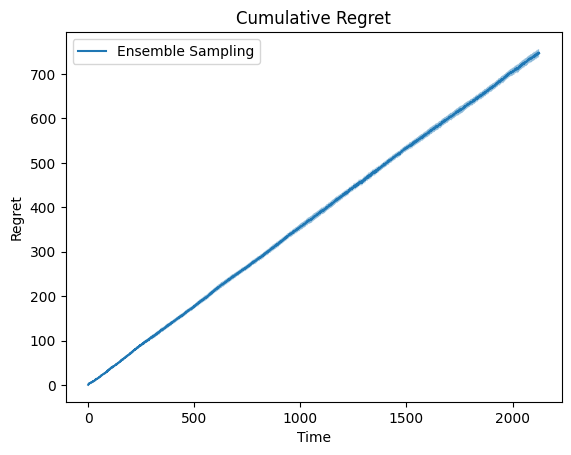

In [93]:
plot_performances(
    np.array(performance_histories['cumulative regret']),
    'Ensemble Sampling',
    'Time',
    'Regret',
    'Cumulative Regret'
)

In [94]:
ensemble_sampling_performance = performance_histories

#### Measure robustness

In [95]:
final_performances = defaultdict(list)

for key, performance_history in performance_histories.items():
    for performance in performance_history:
        final_performances[key].append(performance[-1])

In [96]:
maxlen = max([len(key) for key in final_performances])
for key, values in final_performances.items():
    print(f'{key.ljust(maxlen)}:\t{np.array(values).mean()}')

fraction of incorrect doses:	0.35101081335213913
cumulative regret          :	746.6


In [97]:
ensemble_sampling_robustness = final_performances

# Plots

Plot performance

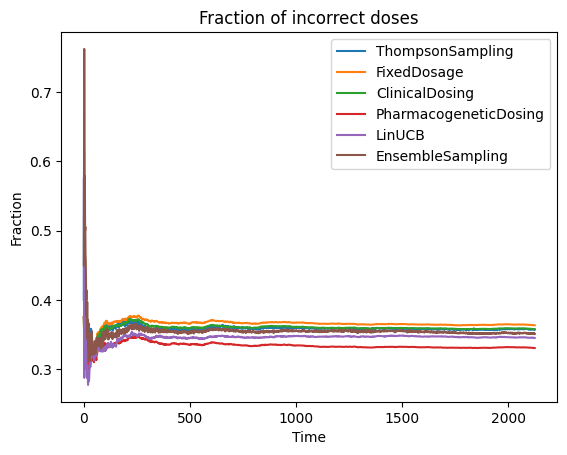

In [98]:
performances = {
    'ThompsonSampling': np.array(thompson_sampling_performance['fraction of incorrect doses']).mean(axis=0),
    'FixedDosage': np.array(fixed_dosage_performance['fraction of incorrect doses']).mean(axis=0),
    'ClinicalDosing': np.array(clinical_dosing_performance['fraction of incorrect doses']).mean(axis=0),
    'PharmacogeneticDosing': np.array(pharmacogenetic_dosing_performance['fraction of incorrect doses']).mean(axis=0),
    'LinUCB': np.array(linucb_performance['fraction of incorrect doses']).mean(axis=0),
    'EnsembleSampling': np.array(ensemble_sampling_performance['fraction of incorrect doses']).mean(axis=0),
}

for key, values in performances.items():
    plt.plot(values, label=key)
    
plt.xlabel('Time')
plt.ylabel('Fraction')
plt.title('Fraction of incorrect doses')
plt.legend()
plt.show()

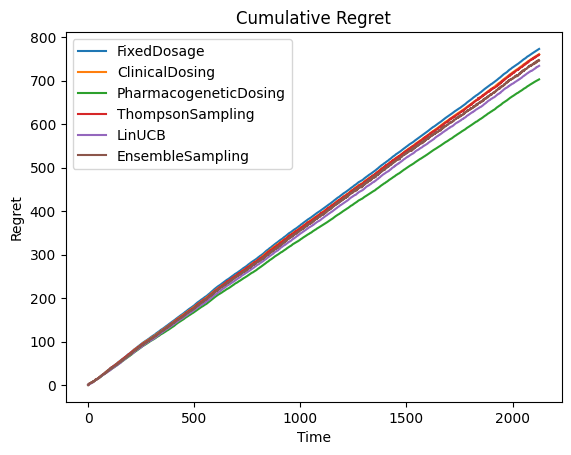

In [99]:
performances = {
    'FixedDosage': np.array(fixed_dosage_performance['cumulative regret']).mean(axis=0),
    'ClinicalDosing': np.array(clinical_dosing_performance['cumulative regret']).mean(axis=0),
    'PharmacogeneticDosing': np.array(pharmacogenetic_dosing_performance['cumulative regret']).mean(axis=0),
    'ThompsonSampling': np.array(thompson_sampling_performance['cumulative regret']).mean(axis=0),
    'LinUCB': np.array(linucb_performance['cumulative regret']).mean(axis=0),
    'EnsembleSampling': np.array(ensemble_sampling_performance['cumulative regret']).mean(axis=0),
}

for key, values in performances.items():
    plt.plot(values, label=key)
    
plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Cumulative Regret')
plt.legend()
plt.show()

Plot robustness

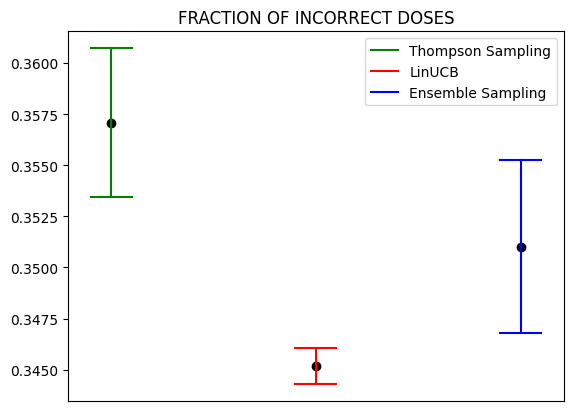

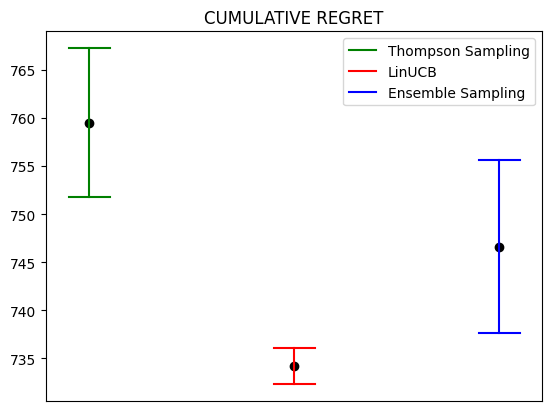

In [100]:
for key in fixed_dosage_robustness:
    data = {
         'Thompson Sampling': thompson_sampling_robustness[key],
         'LinUCB': linucb_robustness[key],
         'Ensemble Sampling': ensemble_sampling_robustness[key],
    }
    plot_ci(data, key.upper())

End